
# Time-Series Sensor Forecasting using TinyML (Steps 1–3)

This notebook demonstrates:
1. Time-series sensor data generation
2. Training a tiny neural network for forecasting
3. Converting the model to TensorFlow Lite (MCU-ready)

Target: Embedded systems (STM32 / ESP32)


## Step 1: Generate Synthetic Sensor Time-Series Data

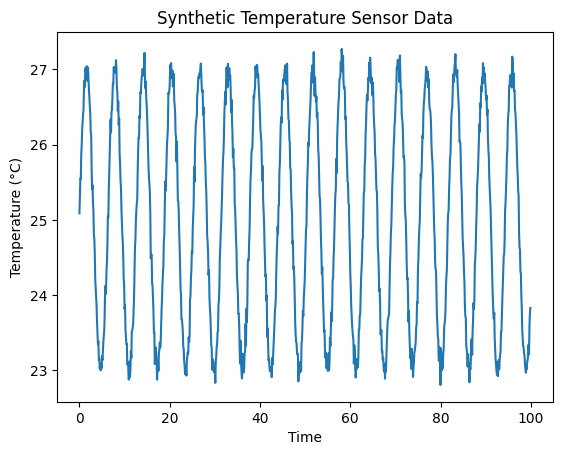

In [182]:

import numpy as np
import matplotlib.pyplot as plt

time = np.arange(0, 100, 0.1)
temperature = 25 + 2*np.sin(time) + 0.1*np.random.randn(len(time))

plt.figure()
plt.plot(time, temperature)
plt.title("Synthetic Temperature Sensor Data")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.show()


## Step 2: Create Sliding Window Dataset

In [183]:

WINDOW_SIZE = 10
X, y = [], []

for i in range(len(temperature) - WINDOW_SIZE):
    X.append(temperature[i:i+WINDOW_SIZE])
    y.append(temperature[i+WINDOW_SIZE])

X = np.array(X)
y = np.array(y)

print("Input shape:", X.shape)
print("Output shape:", y.shape)


Input shape: (990, 10)
Output shape: (990,)


## Step 3: Train a Tiny Neural Network Model

In [184]:

import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape=(WINDOW_SIZE,)),
    tf.keras.layers.Dense(1)
])
#model = tf.keras.Sequential([
#    tf.keras.layers.Dense(8, activation='relu', input_shape=(WINDOW_SIZE,)),
#    tf.keras.layers.Dense(4, activation='relu'),
#    tf.keras.layers.Dense(1)
#])


model.compile(optimizer='adam', loss='mse')

history = model.fit(X, y, epochs=20, batch_size=16)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 177.3884
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2701
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1072
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1057
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1082
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1034
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1016
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1017
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1064
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1017
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1084
Epoch 12/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1000
Epoch 13/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0980
Epoch 14/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1001
Epoch 15/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0956
Epoch 16/20
62/62 ━━━━━━━━━━

## Training Loss Curve

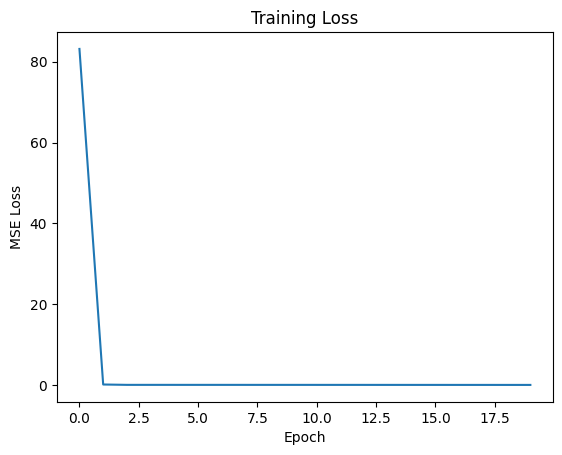

In [185]:

plt.figure()
plt.plot(history.history['loss'])
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()


## Actual vs Predicted Sensor Values

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


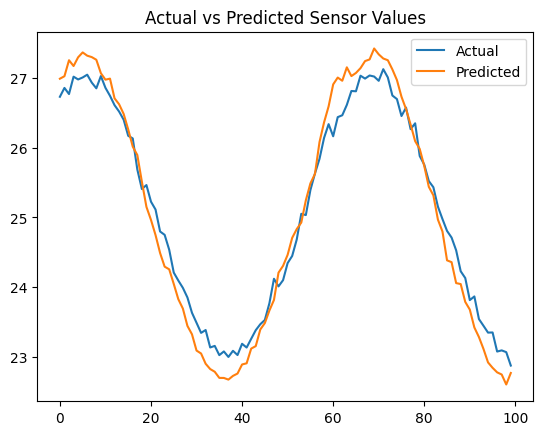

In [186]:

predictions = model.predict(X[:100])

plt.figure()
plt.plot(y[:100], label="Actual")
plt.plot(predictions.flatten(), label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Sensor Values")
plt.show()


In [187]:
#Time →   t-9   t-8   t-7   t-6   t-5   t-4   t-3   t-2   t-1   t
#Temp →  28.1  28.2  28.4  28.5  28.7  28.9  29.0  29.1  29.3  ?
#Goal: Predict temperature at time t+1.

In [188]:
test_input = np.array([[
    28.1, 28.2, 28.3, 28.4, 28.5,
    28.6, 28.7, 28.8, 28.9, 29.0
]])

model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


array([[29.221151]], dtype=float32)

## Convert Model to TensorFlow Lite

In [189]:

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open("sensor_forecast.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model size:", len(tflite_model), "bytes")


Saved artifact at '/tmp/tmpt1nrumzc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10), dtype=tf.float32, name='keras_tensor_73')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137663173251472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137663174342608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137663174340688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137663173255504: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite model size: 1904 bytes
